In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

import calibration_tools as tools

## Loading the data from a single simulation

In [2]:
mu='316.39'
file = '../equilibrium_staging/tip3p/deltamu_' + mu + '/out.nc'
ncfile = Dataset(file,'r')
volume = ncfile.groups['Sample state data']['volume'][:]
nsalt = ncfile.groups['Sample state data']['species counts'][:,1]
ncfile.close()

## Viewing the trace of the salt numbers

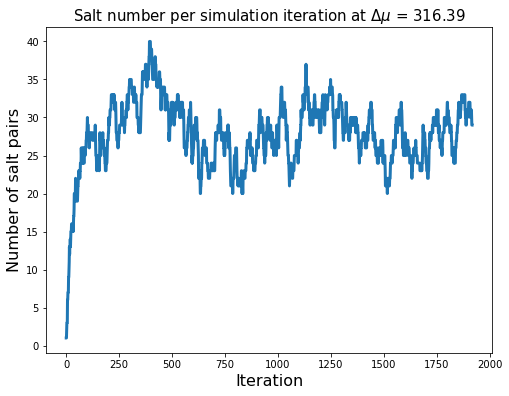

In [3]:
plt.figure(figsize=[8,6])
plt.plot(nsalt, lw=3)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Number of salt pairs', fontsize=16)
plt.title('Salt number per simulation iteration at $\Delta \mu$ = {0}'.format(mu), fontsize=15)
plt.show()

## Viewing the distribution of salt in a single simulation

In [4]:
# Choosing a burn-in based on the above
burnin = 250
concentrations = 1.0*nsalt[burnin:]/volume[burnin:] * 1.66054

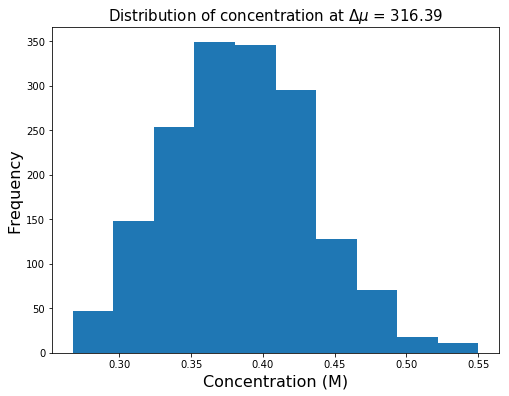

In [5]:
plt.figure(figsize=[8,6])
plt.hist(concentrations)
plt.title('Distribution of concentration at $\Delta \mu$ = {0}'.format(mu), fontsize=15)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Concentration (M)', fontsize=16)
plt.show()

## How well do my predictions match my simulations?
Looking at all simulations

Extract the tip3p calibration results with uncertainties

In [6]:
files = ['../sams/tip3p/out1.nc', '../sams/tip3p/out2.nc', '../sams/tip3p/out3.nc']
t3p = tools.AutoAnalyzeCalibration(files)

In [7]:
mu = [314.85, 315.24, 315.68, 316.39, 317.61, 318.78, 319.83]
burnin=250
mean_concentrations = np.zeros(len(mu))
for i in range(len(mu)):
    # Read in data
    file = '../equilibrium_staging/tip3p/deltamu_' + str(mu[i]) + '/out.nc'
    ncfile = Dataset(file,'r')
    volume = ncfile.groups['Sample state data']['volume'][:]
    nsalt = ncfile.groups['Sample state data']['species counts'][:,1]
    ncfile.close()
    
    # Get the concentrations
    concentrations = 1.0*nsalt[burnin:]/volume[burnin:] * 1.66054
    mean_concentrations[i] = np.mean(concentrations)

Generating an ensemble of predicted concentrations from the BAR and volume uncertainties during calibration.

In [8]:
plot_mus = np.linspace(mu[0],mu[-1])
pred_concentration, pred_spread =  t3p.predict_ensemble_concentrations(deltachems=plot_mus, nsamples=200)

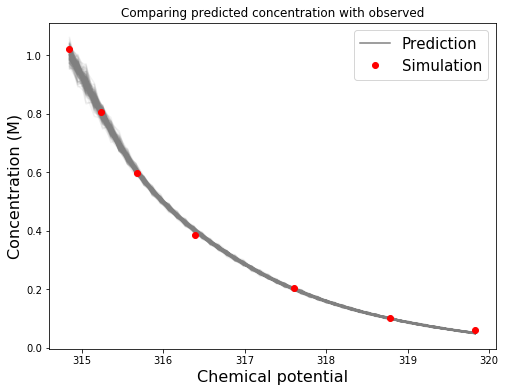

In [9]:
plt.figure(figsize=[8,6])
plt.plot(plot_mus, pred_concentration,color='grey', label='Prediction')
plt.plot(plot_mus, pred_spread, alpha=0.1, color='grey')
plt.plot(mu, mean_concentrations,'o', color='red', label='Simulation')

plt.title('Comparing predicted concentration with observed')
plt.xlabel('Chemical potential', fontsize=16)
plt.ylabel('Concentration (M)', fontsize=16)
plt.legend(fontsize=15)
plt.show()